In [36]:
import numpy as np
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [37]:
train_directory="C:/Users/Benson/Downloads/Xray_PA_Dataset/train"
val_directory="C:/Users/Benson/Downloads/Xray_PA_Dataset/val"
test_directory="C:/Users/Benson/Downloads/Xray_PA_Dataset/test"

In [38]:
data_dir = train_directory
class_names = os.listdir(train_directory)
print(class_names)

['normal', 'pneumonia']


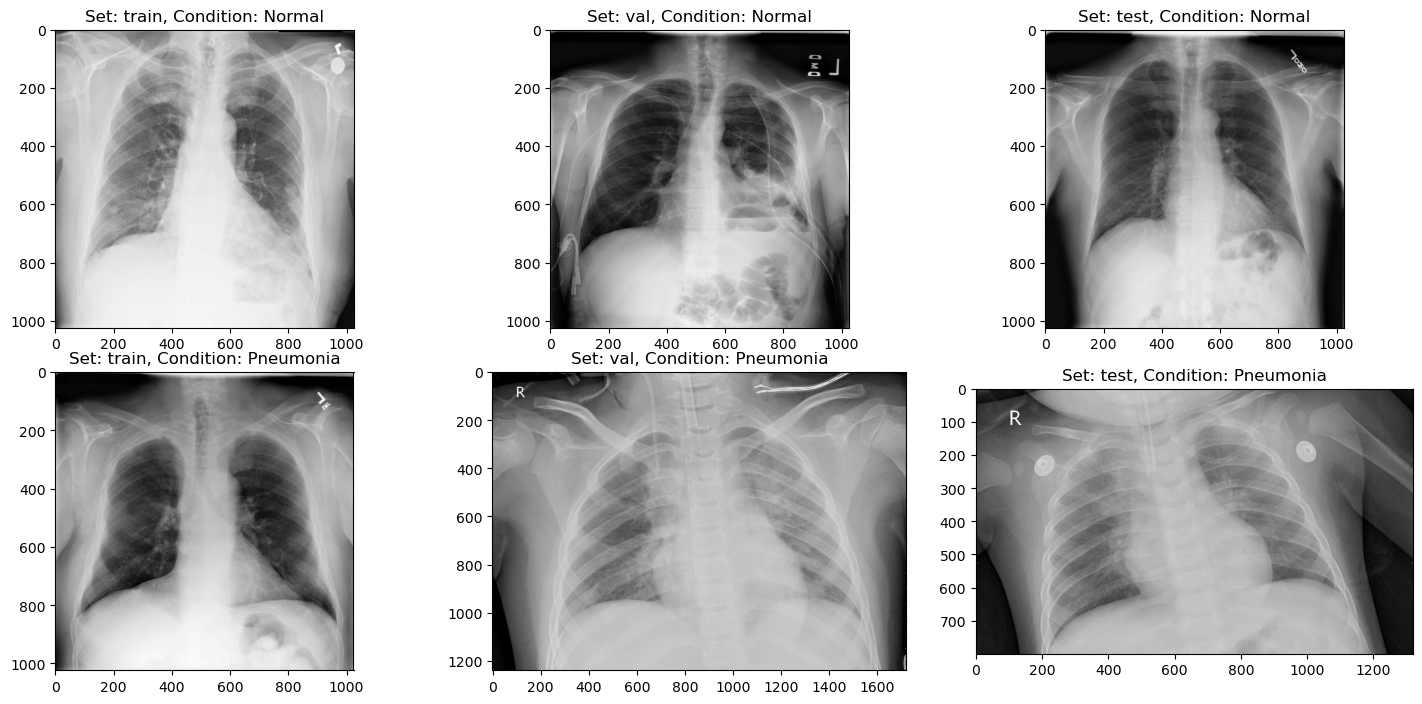

In [39]:
input_path="C:/Users/Benson/Downloads/Xray_PA_Dataset/"
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [40]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Under: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Under: train, Normal images: 1200, pneumonia images: 1200
Under: val, Normal images: 50, pneumonia images: 50
Under: test, Normal images: 275, pneumonia images: 275


In [41]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [42]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [43]:
train = Image_gen.flow_from_directory(train_directory,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = Image_gen.flow_from_directory(val_directory,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_directory,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 2400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [44]:
img, label = next(train)

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [46]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=8)

In [47]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False 

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model
res_model = create_model()
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

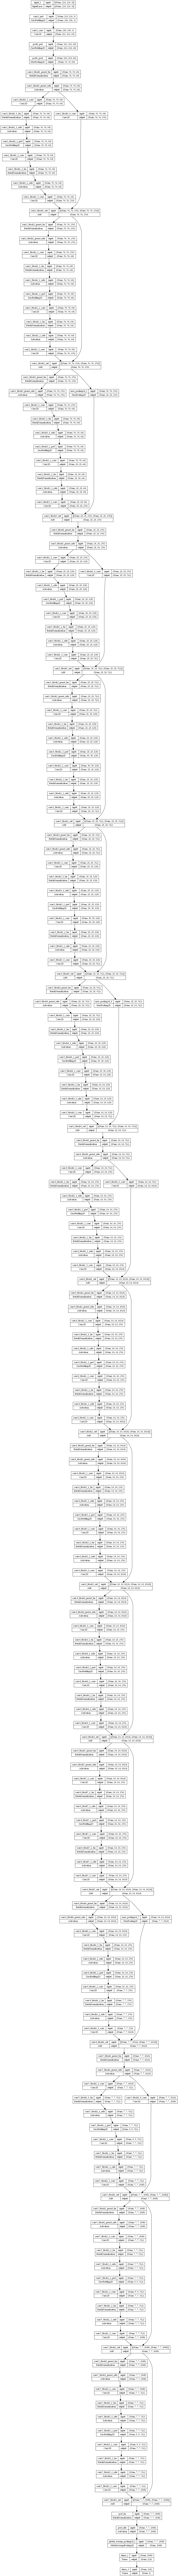

In [48]:
plot_model(res_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_model.png'))

In [49]:
history = res_model.fit(train,epochs=10, 
                    validation_data=validation,
                     steps_per_epoch=50,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/10
50/50 [==============================] - 157s 3s/step - loss: 0.3689 - accuracy: 0.8494 - val_loss: 0.2724 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 164s 3s/step - loss: 0.2786 - accuracy: 0.8950 - val_loss: 0.1685 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 180s 4s/step - loss: 0.2363 - accuracy: 0.9200 - val_loss: 0.1784 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - 195s 4s/step - loss: 0.2587 - accuracy: 0.9069 - val_loss: 0.1228 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 185s 4s/step - loss: 0.2273 - accuracy: 0.9237 - val_loss: 0.1292 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/10
50/50 [==============================] - 186s 4s/step - loss: 0.2331 - accuracy: 0.9144 - val_loss: 0.1081 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/10
50/50 [==============================] - 177s 4s/step - loss: 0.2

Text(0, 0.5, 'Loss')

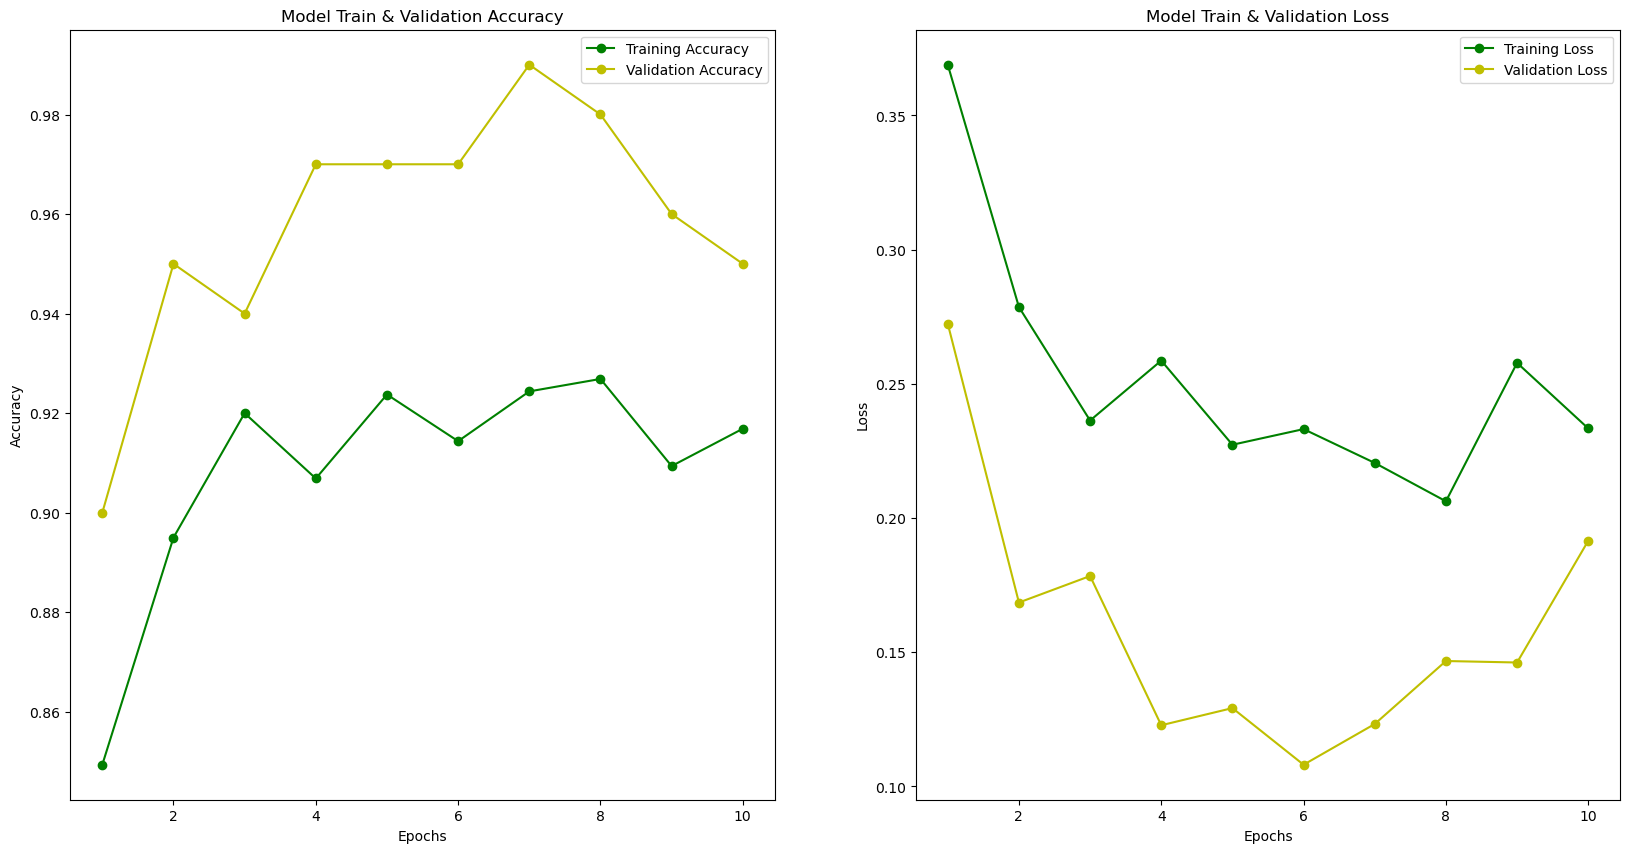

In [50]:
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')


In [51]:
score = res_model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

75/75 [==============================] - 231s 3s/step - loss: 0.2261 - accuracy: 0.9162
Train Loss:  0.22606410086154938
Train Accuracy:  0.9162499904632568
275/275 [==============================] - 66s 240ms/step - loss: 0.2635 - accuracy: 0.9055

Test loss:  0.26349544525146484
Test Accuracy:  0.9054545164108276


In [55]:
SEED = 0
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
tf.random.set_seed(SEED)
np.random.seed(SEED)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    label_mode='categorical',
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)



Found 2400 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 550 files belonging to 2 classes.


In [56]:
from tensorflow.keras import models,layers

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2,0.3),

])

train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [57]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=2,
    restore_best_weights=True,
)

In [58]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications

base_model =applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
model_Inc = Sequential(resize_and_rescale)
model_Inc.add(base_model)
model_Inc.add(GlobalAveragePooling2D())
model_Inc.add(Dropout(0.5))
model_Inc.add(Dense(64, 
                    activation='relu'))
model_Inc.add(Dense(16, 
                    activation='relu'))
model_Inc.add(Dense(2, 
                    activation='softmax'))
model_Inc.build(input_shape=(32,224,224,3))

model_Incep = model_Inc
LR = 0.001

model_Incep.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
                metrics=["accuracy"])

In [ ]:
  history = model_Incep.fit(train_data,
                      validation_data=valid_data,
                      epochs=10,
                      verbose=True,
                      callbacks=[early_stopping]
                      )

Epoch 1/10
75/75 [==============================] - 588s 8s/step - loss: 0.6778 - accuracy: 0.5700 - val_loss: 0.6092 - val_accuracy: 0.7400
Epoch 2/10
40/75 [===============>..............] - ETA: 4:20 - loss: 0.5846 - accuracy: 0.7180

Text(0.5, 1.0, 'Accuracy')

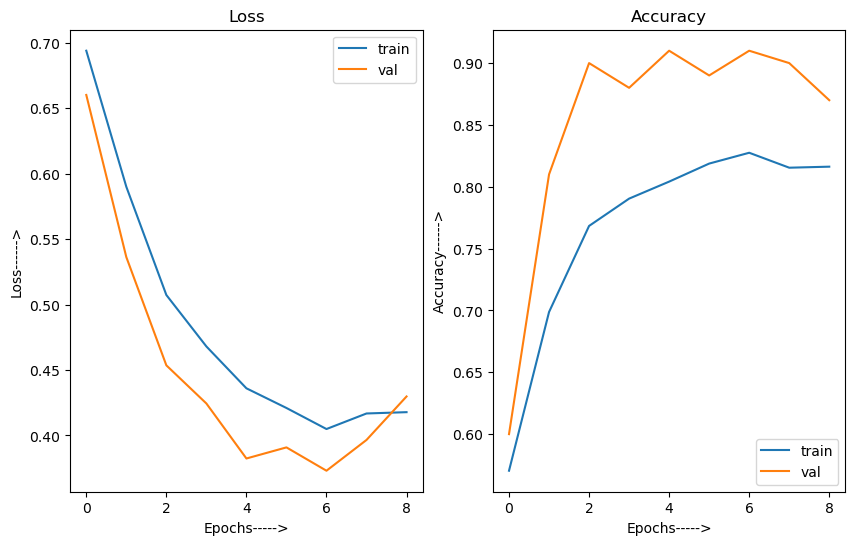

In [82]:
   df=pd.DataFrame(history.history)
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(df[['loss','val_loss']])
plt.xlabel("Epochs----->")
plt.ylabel("Loss------>")
plt.legend(['train','val'])
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(df[['accuracy','val_accuracy']])
plt.xlabel("Epochs----->")
plt.ylabel("Accuracy------>")
plt.legend(['train','val'])
plt.title("Accuracy")

1/1 [==============================] - 0s 486ms/step


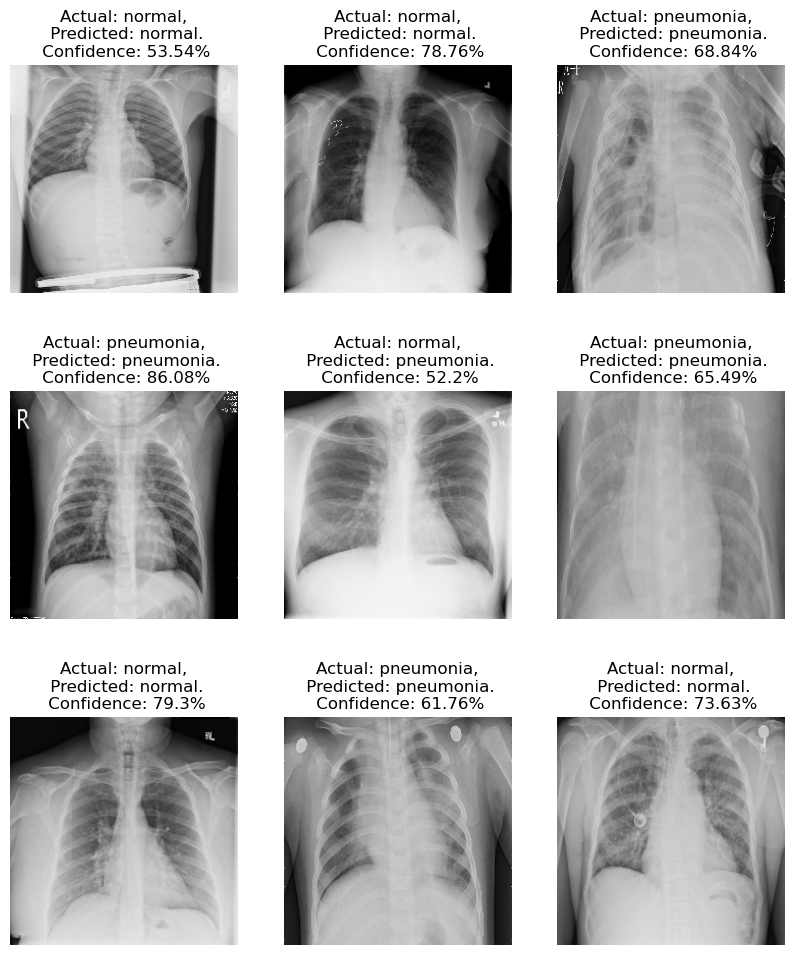

In [83]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

import numpy as np
plt.figure(figsize=(10, 12))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_Incep, images[i].numpy())

        actual_class = class_names[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")